In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
creds = ''

In [3]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
path = Path('phrase')

In [5]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [6]:
if iskaggle:
    path = Path('../input/phrase')
    ! pip install -q datasets

In [7]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [8]:
import pandas as pd

In [9]:
df = pd.read_csv(path/'train.csv')

In [10]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [11]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [12]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [13]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

## Tokenização

In [14]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)

In [15]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [16]:
model_nm = 'microsoft/deberta-v3-small'

In [17]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:457: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

In [19]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [20]:
def tok_func(x): return tokz(x["input"])

In [21]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [22]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [23]:
tokz.vocab['▁of']

265

In [24]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

## Teste e validação

In [25]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


### Validation set

In [26]:
def f(x): return -3*x**2 + 2*x + 20

In [27]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

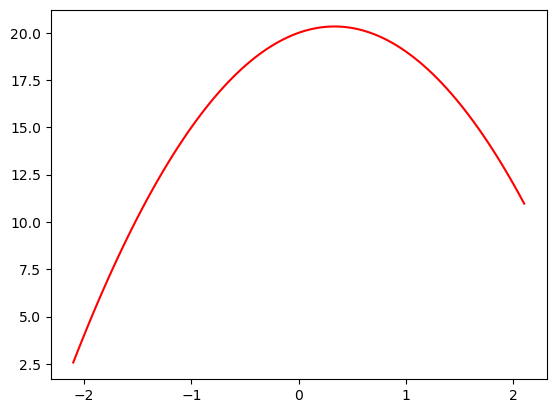

In [28]:
plot_function(f)

In [29]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

In [30]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

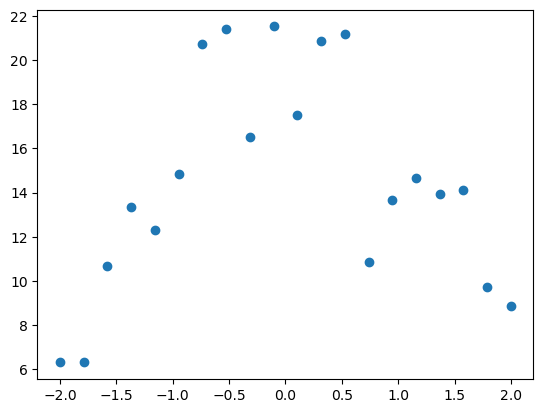

In [31]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

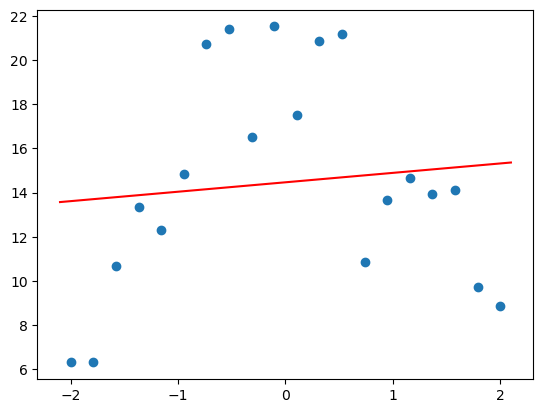

In [33]:
plot_poly(1)

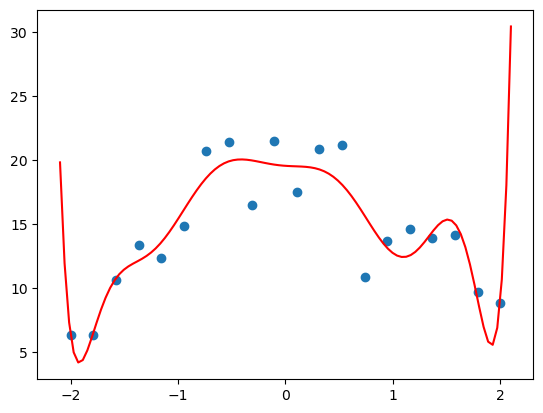

In [34]:
plot_poly(10)

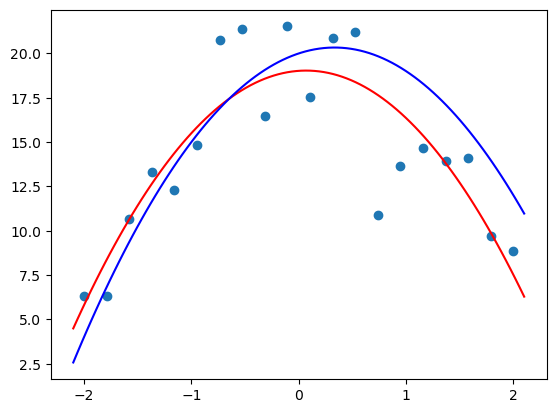

In [35]:
plot_poly(2)
plot_function(f, color='b')

In [36]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

### Test set

In [37]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

## Métricas

In [38]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [39]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [40]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [41]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906006

In [42]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

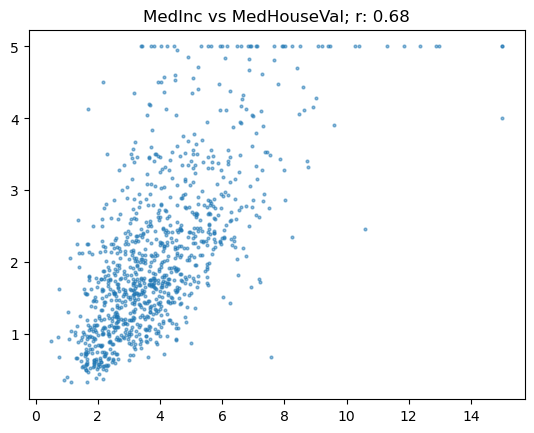

In [43]:
show_corr(housing, 'MedInc', 'MedHouseVal')

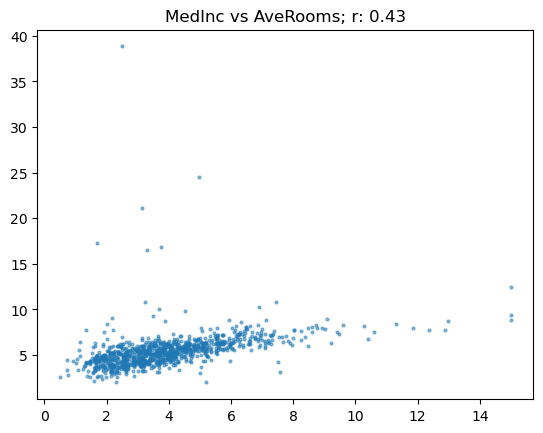

In [44]:
show_corr(housing, 'MedInc', 'AveRooms')

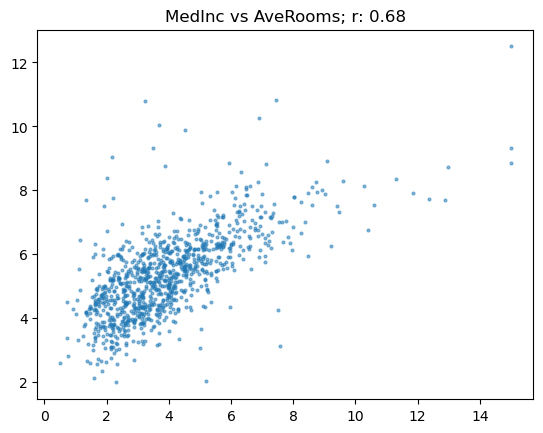

In [45]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

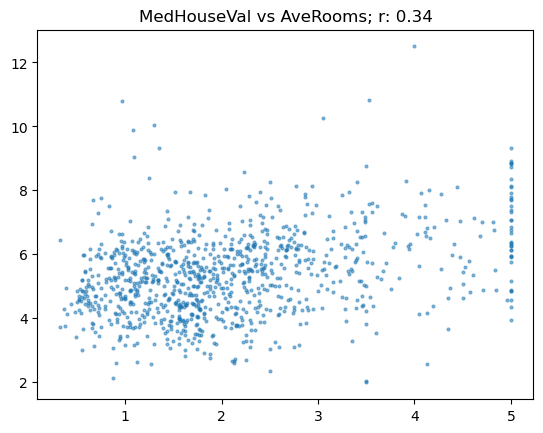

In [46]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

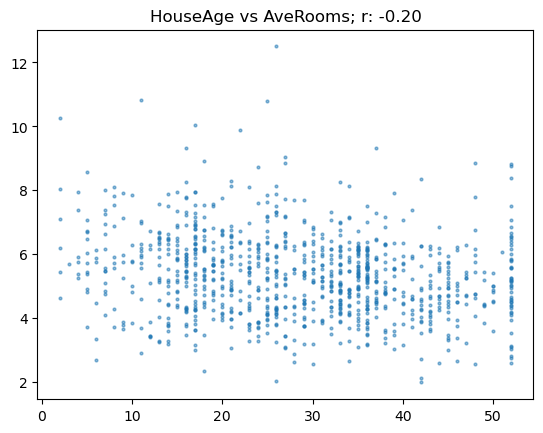

In [47]:
show_corr(subset, 'HouseAge', 'AveRooms')

In [48]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

## Treino

In [49]:
! pip install -U git+https://github.com/huggingface/transformers.git
! pip install -U git+https://github.com/huggingface/accelerate.git
from transformers import TrainingArguments,Trainer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-vz3sjwrw
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-vz3sjwrw
  Resolved https://github.com/huggingface/transformers.git to commit 66ded238cd04e29ba98485984dd647e7d37d1603
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenize

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [50]:
bs = 128
epochs = 4

In [51]:
lr = 8e-5

In [52]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [53]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['pooler.dense.weight', 'classifier.weight', 'pooler.dense.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
trainer.train();

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026560,0.797175
2,No log,0.022440,0.820540
3,0.033700,0.021870,0.832021
4,0.033700,0.022563,0.831739


In [55]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[ 0.51],
       [ 0.66],
       [ 0.58],
       [ 0.32],
       [-0.05],
       [ 0.59],
       [ 0.5 ],
       [ 0.05],
       [ 0.29],
       [ 1.1 ],
       [ 0.23],
       [ 0.23],
       [ 0.71],
       [ 0.92],
       [ 0.74],
       [ 0.4 ],
       [ 0.23],
       [-0.02],
       [ 0.66],
       [ 0.35],
       [ 0.44],
       [ 0.24],
       [ 0.02],
       [ 0.24],
       [ 0.56],
       [-0.04],
       [-0.04],
       [-0.04],
       [-0.04],
       [ 0.65],
       [ 0.29],
       [-0.03],
       [ 0.69],
       [ 0.53],
       [ 0.37],
       [ 0.23]])

In [56]:
preds = np.clip(preds, 0, 1)

In [57]:
preds

array([[0.51],
       [0.66],
       [0.58],
       [0.32],
       [0.  ],
       [0.59],
       [0.5 ],
       [0.05],
       [0.29],
       [1.  ],
       [0.23],
       [0.23],
       [0.71],
       [0.92],
       [0.74],
       [0.4 ],
       [0.23],
       [0.  ],
       [0.66],
       [0.35],
       [0.44],
       [0.24],
       [0.02],
       [0.24],
       [0.56],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.65],
       [0.29],
       [0.  ],
       [0.69],
       [0.53],
       [0.37],
       [0.23]])

In [58]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

855